# Project 2. Continuous Control
In this project, I trained a robot agent that reaches a ball using Deep Deterministic Policy Gradient (DDPG).

## 1. Problem Definition

### Environment
The problem environment is a 3d space. It has one or 20 robot agents and their target balls that are generated randomly around them. 

<img src="assets/reacher_random.gif"/>

### Task
The agent's goal is to move its arm to reach the target ball and keep it there.

### State
The agent observes a state with 33 variables that contain position, rotation, velocity and angular velocities of the arm. 

### Action
The agent's action is a vector of 4 numbers that are torque applicable to two joints.
These numbers are ranged between -1 and 1. 

### Reward
The agent gains +0.1 when its hand is touching the target ball.

### Completion Target
The task is considered solved when the average score gets better than 30 over 100 episodes.

### Algorithm
In this project I'm going to use DDPG.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='Reacher_multi.app')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 2. DDPG

### Motivation
Despite of its success with Atari Games, the use of Deep Q Network(DQN) is limited to tasks with discrete and low-dimensional action spaces. In the previous project, DQN agent solved LunarLander-v2 where it only had to choose "Left", "Right", "Down" and "Do Nothing". However, DQN is not suitable for tasks that have continuous and high dimensional action spaces due to the way it works. DQN learns to estimate values of each possible action, and updates its weights via choosing the action that maximizes the action-value function. To deal with infinite number of real-valued actions ranging from "Left 50.0001m" to "Left 59.999m" DQN's output layer would have infinite number of neurons, which is simply not feasible. One could discretize the continuous actions into a number of discrete actions. But doing so cannot avoid the curse of dimensionality and information loss.

Deep Deterministic Policy Gradient is born to overcome such limitation. It is model-free, off-policy, actor-critic reinforcement learning algorithm that uses deep learning as a function approxiamtor. DDPG can handle continuous action spaces and learn policies from high dimensional input data.

### Key Ideas
DDPG combines actor-critic architecture with insights from DQN.   
 - DQN: DDPG's critic draws experience tuples from Experience Replay Buffer like DQN. Plus, each actor and critic network have their own target copies to update parameters.
- Actor-Critic: DDPG architecture has two separate networks: actor network that outputs next action, and critic network that estimates its value.  
 - Actor: DDPG's actor uses deterministic policy that outputs best action for a given state $\mu(s; \theta^\mu$). Thanks to the deterministic policy it can produce any real-valued actions via tanh or sigmoid activation at the end of the network.
 - Critic: DDPG's critic learns to evaluate the optimal action value function of the best action provided by the actor. $Q(s, \mu(s;\theta^\mu);\theta^Q)$ 
 - Ornstein-Uhlenbeck process: The authors used Ornstein-Uhlenbeck process to add noise to encourage exploration of the agent. This process produces zero-mean values that are temporarily correlated to each other. 
 - Soft Update: DQN's network gets a big update every 10,000 steps. DDPG suggests a much subtle way of updating parameters. At every step DDPG blends a tiny portion $\tau$ of local network with the target network. This enables more stable learning.

 
### Pseudo code
- Randomly Initialze critic network $Q(s, a|\theta^Q)$ and actor $\mu(s|\theta^\mu)$ with weights $\theta^Q$ and $\theta^\mu$
- Initialize target network $Q^\prime$ and $\mu^\prime$ with weights $\theta^{Q^\prime} \leftarrow \theta^Q$, $\theta^{\mu^\prime} \leftarrow \theta^\mu$
- Initialize replay buffer
- for episode = 1, M do
  - Initialize a random process $N$ for action exploration
  - Receive initial observation state $s_1$
  - for t=1, T do
    - Select action $a_t = \mu(s_t|\theta^\mu) + N_t$ according to the current policy and exploration noise
    - Execute action $a_t$ and observe reward $r_t$ and observe new state $s_{t+1}$
    - Store transition $(s_t, a_t, r_t, s_{t+1})$ in $R$
    - Sample a random minibatch of N transitions $(s_i, a_i, r_i, s_{i+1})$ from $R$
    - Set $y_i = r_i + \gamma Q^\prime(s_{i+1}, \mu^\prime(s_{i+1}|\theta^{\mu^\prime}) | \theta^{Q^\prime})$
    - Update critic by minimising the loss: $L = \frac{1}{N} \Sigma_i(y_i - Q(s_i, a_i | \theta^Q))^2$
    - Update the actor policy using the sampled policy gradient:
    $$\triangledown_{\theta^\mu}J \approx \frac{1}{N} \Sigma_i \triangledown_a Q(s, a|\theta^Q)|_{s=s_i, a=\mu(s_i}\triangledown_{\theta^\mu}\mu(s|\theta^\mu)|_{s_i}$$
    - Update the target networks:
    $$\theta^{Q^\prime} \leftarrow \tau \theta^Q + (1 - \tau)\theta^{Q^\prime}$$
    $$\theta^{\mu^\prime} \leftarrow \tau \theta^\mu + (1 - \tau)\theta^{\mu^\prime}$$
  - end for
- end for

## 3. Implementation Details

### 3-1. Actor Network

- takes state (33 variables) as input
- outputs action vector that has 4 numbers that are ranged between -1 and +1 through tanh activation
- has two hidden layers that have 256 and 128 neurons
<img src="assets/actor_nn.png" width="500px"/>


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def hidden_init(layer):
    """
    The weight initialization method used by the authors of DDPG paper
    > The other layers were initialized from uniform distributions [-1/np.sqrt(f), 1/np.sqrt(f)]
    > where f is the fan-in of the layer.
    """
    fan_in = layer.weight.data.size(0)
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor Model"""
    
    def __init__(self, state_size, action_size, seed, fc1_size=256, fc2_size=128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(fc2_size, action_size)
        self.tanh_out = nn.Tanh()
        
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = self.fc1(state)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        x = self.tanh_out(x)
        
        return x

### 3-2. Critic Network
- takes state (33 variables) as input
- concat the output of the first hidden layer and actions from Actor Network before the second hidden layer
- outputs a single value that represents the estimated value of the given state
- two hidden layers have 256 and 128 neurons respectively
<img src="assets/critic_nn.png" width="500px"/>


In [3]:
class Critic(nn.Module):
    """Critic Network"""
    def __init__(self, state_size, action_size, seed, fc1_size=256, fc2_size=128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(fc1_size + action_size, fc2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(fc2_size, 1)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        x = self.fc1(state)
        x = self.relu1(x)
        
        x = torch.cat((x, action), dim=1)
        x = self.fc2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        return x

### 3-3. Actor-Critic
1. observe $s_t$
2. pick action $a_t$ from actor_local  
  2-1. pick action  
  2-2. add Orstein-Uhlenbeck noise  
  2-3. clip from -1 to +1  
3. get $r_{t+1}, s_{t+1}$  
  3-1. append the experience tuple $(s_t, a_t, r_{t+1}, s_{t+1})$ to the replay buffer  
  3-2. draw sample experience tuples from the replay buffer  
  3-3. learn from the samples and run updates  
    1. get action_next from actor_target with $s_{t+1}$ (predict the next action)  
    2. calculate value of action_next with $s_{t+1}$ via critic_target (estimate the value of that action)  
    3. get the target estimate with $r_{t+1}$ and discounted value from 2 (set the target value with TD estimate)  
    4. calculate the TD error from 3 and critic local's estimate of $s_t, a_t$ to update critic_local (update Critic with TD error)  
    5. get actor_local's predicted actions from the states, then estimate their values from the critic_local to update actor_local (the predicted actions can be different from $a_t$ as actor_local)  
    6. update target networks via soft updates  
    
<img src="assets/actor_critic_update.png" width="800px"/>


In [4]:
# Ornstein-Uhlenbeck process implementation from ShangtongZhang
class RandomProcess(object):
    def reset_states(self):
        pass

class OrnsteinUhlenbeckProcess(RandomProcess):
    def __init__(self, size, seed, mu=0., std=0.2, theta=.15, dt=1e-2, x0=None):
        self.size = size
        self.seed = random.seed(seed)
        
        self.mu = mu
        self.std = std
        self.theta = theta
        self.dt = dt
        
        self.x0 = x0
        self.reset_states()
        
    def sample(self):
        x = self.x_prev + \
            self.theta * (self.mu - self.x_prev) * self.dt + \
            self.std * np.sqrt(self.dt) * np.random.randn(*self.size)
        self.x_prev = x
        return x
    
    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

In [5]:
class ReplayBuffer:
    def __init__(self, seed, device, action_size, buffer_size, batch_size):
        self.DEVICE = device
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])
        
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.DEVICE)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.DEVICE)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.DEVICE)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.DEVICE)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.DEVICE)

        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

In [6]:
import random
import copy
import os
from collections import namedtuple, deque

import torch.optim as optim

class DDPGAgent():
    def __init__(self, random_seed, device, n_agents, state_size, action_size,
                buffer_size, batch_size, gamma, tau, lr_actor, lr_critic, weight_decay, checkpoint_folder= "ckpt"):
        
        if not os.path.exists(checkpoint_folder):
            os.makedirs(checkpoint_folder)
        
        self.seed = random.seed(random_seed)
        self.DEVICE = device
        self.n_agents = n_agents
        
        self.state_size = state_size
        self.action_size = action_size
        
        # hyper-paramters
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.weight_decay = weight_decay
        self.checkpoint_folder = checkpoint_folder
        
        # local and target actors and critics
        self.actor_local = Actor(state_size, action_size, random_seed).to(self.DEVICE)
        self.actor_target = Actor(state_size, action_size, random_seed).to(self.DEVICE)
        self.actor_local_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.lr_actor)
        
        self.critic_local = Critic(state_size, action_size, random_seed).to(self.DEVICE)
        self.critic_target = Critic(state_size, action_size, random_seed).to(self.DEVICE)
        self.critic_local_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.lr_critic)
        
        # Ornstein-Uhlenbeck noise process
        self.noise = OrnsteinUhlenbeckProcess((n_agents, action_size), random_seed)
        
        # Replay Buffer
        self.memory = ReplayBuffer(random_seed, device, action_size, self.buffer_size, self.batch_size)
        
        
    def step(self, state, action, reward, next_state, done):
        """
        1. append experience to the replay memory
        2. take random samples from the replay memory
        3. learn from those samples
        """
        
        #1
        for i in range(self.n_agents):
            self.memory.add(state[i], action[i], reward[i], next_state[i], done[i])
            
        
        #2
        if len(self.memory) > self.batch_size:
            samples_drawn = self.memory.sample()
            
            #3
            self.learn(samples_drawn)
            
    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(self.DEVICE)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            ohnoise = self.noise.sample()
            action += ohnoise
        return np.clip(action, -1, 1)
            
    
    def reset(self):
        self.noise.reset_states()
        
    def learn(self, experiences):
        
        states, actions, rewards, next_states, dones = experiences
        
        # update critic
        #1. use actor_target to predict the next actions for the next states
        predicted_next_actions = self.actor_target(next_states)
        
        #2. use critic_target to estimate the value of the predicted next actions
        estimated_values_of_predicted_next_actions = self.critic_target(next_states, predicted_next_actions)
        
        #3. calculate Q targets with the immediate reward and discounted value of #2
        #if the next state is done, discounted #2 is 0
        Q_targets = rewards + (self.gamma * estimated_values_of_predicted_next_actions * (1-dones))
        
        #4. use critic_local to estimate Q expected from states and actions of the sample experience
        Q_expected = self.critic_local(states, actions)
        
        #5. calculate MSE loss between Q expected and Q targets
        #Q_targets based on critic_target, Q_expected based on critic_local
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        #6. minimise #5 using optimizer and backward to update critic_local
        #that is learning the value of current state and action
        self.critic_local_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_local_optimizer.step()
        
        
        
        # update actor
        #1 use actor_local to predict the next action without Ornstein-Uhlenbeck noise
        #this shows actor_local's current progress
        predicted_actions_wo_noise = self.actor_local(states)
        
        #2 use critic_local to estimate the value of actor_local's predicted actions
        #take mean of the values of (states, actions)
        estimated_value_of_predicted_actions = self.critic_local(states, predicted_actions_wo_noise).mean()
        
        #3 loss is the minus of #2 as we use gradient descient to maximize the estimated value
        actor_loss = -estimated_value_of_predicted_actions
        
        #4 minimize #3 to update actor_local
        self.actor_local_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_local_optimizer.step()
        
        # update target network using soft update
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target)
        
        
    def soft_update(self, local_nn, target_nn):
        for target_parameter, local_parameter in zip(target_nn.parameters(), local_nn.parameters()):
            target_parameter.data.copy_(self.tau * local_parameter.data + (1.0 - self.tau) * target_parameter.data)
        
    
    
    def save_checkpoints(self, suffix):
        if not os.path.exists(self.checkpoint_folder):
            os.makedirs(self.checkpoint_folder)
        torch.save(self.actor_local.state_dict(), self.checkpoint_folder + '/actor_{}.pth'.format(str(suffix)))
        torch.save(self.critic_local.state_dict(), self.checkpoint_folder + '/critic_{}.pth'.format(str(suffix)))

In [7]:
def ddpg_train(agent, n_agents, n_episodes, len_scores=100):
    
    #base_score
    base_score = 0
    
    #score logging
    scores = []
    scores_window = deque(maxlen=len_scores)
    
    #for every episode
    for episode in range(n_episodes):
        
        #reset env
        env_info = env.reset(train_mode=True)[brain_name]
        
        #get states
        states = env_info.vector_observations
        
        #reset agent
        agent.reset()
        
        #reset score
        score = np.zeros(n_agents)
        
        #run until game ends
        while True:
            
            # decide actions for the current state
            actions = agent.act(states)
            
            # execute actions
            env_info = env.step(actions)[brain_name]
            
            # get next_states, rewards, dones
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            # learn the agent
            agent.step(states, actions, rewards, next_states, dones)
            
            # update score
            score += rewards
            
            # update current states with the next_states
            states = next_states
            
            # if any of the agents are done, break
            if np.any(dones):
                break
                
        scores.append(np.mean(score))
        scores_window.append(np.mean(score))
        
        # save actor and critic checkpoints
        if np.mean(scores_window) > base_score:
            agent.save_checkpoints("score{}".format(int(np.mean(scores_window))))
            base_score += 10
        
        print('\rEpisode: \t{} \tScore: \t{:.2f} \tAverage Score: \t{:.2f}'.format(episode, np.mean(score), np.mean(scores_window)), end="")  
        
        if np.mean(scores_window) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            agent.save_checkpoints("solved")
            break
            
    return agent, scores
        

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
agent = DDPGAgent(random_seed=42, 
                  device=device, 
                  n_agents=num_agents, 
                  state_size=state_size,
                  action_size=action_size, 
                  buffer_size=int(1e5), 
                  batch_size=128, 
                  gamma=0.99, 
                  tau=0.001, 
                  lr_actor=1e-4, 
                  lr_critic=1e-4, 
                  weight_decay=0.0)

learned_agent, scores = ddpg_train(agent, n_agents=num_agents, n_episodes=1000, len_scores=100)

Episode: 	119 	Score: 	32.44 	Average Score: 	30.26
Environment solved in 119 episodes!	Average Score: 30.26


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

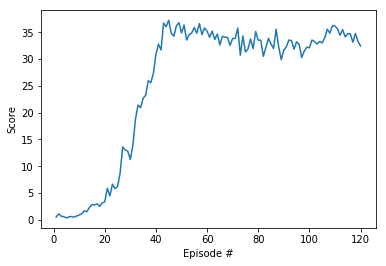

In [11]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(scores)+1), scores)
ax.set_ylabel("Score")
ax.set_xlabel("Episode #")
plt.show()

# 4. Test Result

## Agent - score 0
<img src="assets/reacher_score0.gif"/>

<br>

## Agent - score 10
<img src="assets/reacher_score10.gif"/>

<br>

## Agent - score 30 (solved)
<img src="assets/reacher_solved.gif"/>

# 5. Ideas for Future Work

In this project I used DDPG algorithm to train an agent and it successfully solved Reacher task. Here are some ideas to improve agent performance and make training more efficient:

- Batch Normalization: I did not use batch-normalization for this version of implementation. As it's proven to help stabilize training with deep networks I should give it a go when solving more complex tasks.
- Different noise process: DDPG uses Ornstein-Uhlenbeck process to add exploration noise during training. I wonder if other noise process would work or perform even better.